# TUTORIAL 01: 
# Using Data assimilation to update the ESN prediction on the fly
#### Benefits
1. No need for a washout
2. We can update the reservoir state 


In [1]:
# Load required packages
from default_parameters.lorenz63 import *
from ML_models.EchoStateNetwork import *
from copy import deepcopy


## 1. DEFINE THE ESN PARAMETERS

In [12]:
dt_model = 0.015
t_lyap = 0.906 ** (-1)  # Lyapunov Time (inverse of largest Lyapunov exponent

# Define Echo state network parameters
ESN_params = dict(t_train=40 * t_lyap,
                  t_val=6 * t_lyap,
                  t_test=10 * t_lyap,
                  N_wash=5,
                  N_units=50,
                  N_folds=8,
                  N_split=5,
                  connect=3,
                  plot_training=True,
                  rho_range=(.2, .8),
                  tikh_range=[1E-6, 1E-9, 1E-12],
                  N_func_evals=40,
                  sigma_in_range=(np.log10(0.5), np.log10(50.)),
                  N_grid=5,
                  noise=1e-2,
                  perform_test=True,
                  Win_type='sparse',
                  upsample=3,
                  bayesian_update=True
                  )


# Initialize ESN class
ESN_original = EchoStateNetwork(y=np.zeros((3,1)), dt=dt_model, **ESN_params)



## 2. GENERATE THE TRAINING DATA

In [13]:
# Create training data from the Lorenz 63 model
model = Lorenz63(dt=dt_model,
                 psi0=rng.random(3)+10,
                 t_transient=10 * t_lyap,
                 t_lyap=t_lyap)

# Initialise ensemble of training data
N_transient = int(model.t_transient / model.dt)
model.update_history(model.time_integrate(Nt=N_transient)[0][-1], reset=True)


N_wtv_model = int((ESN_params['t_train'] + ESN_params['t_val']) / model.dt)\
              + ESN_params['N_wash'] * ESN_params['upsample']
N_test_model = int(ESN_params['t_test'] / model.dt) * 5

for Nt in [N_wtv_model, N_test_model]:
    state, t1 = model.time_integrate(Nt)
    model.update_history(state, t1)
model.close()

[Text(0.5, 0, '$t/T$'), (0.0, 96.13566000000002)]

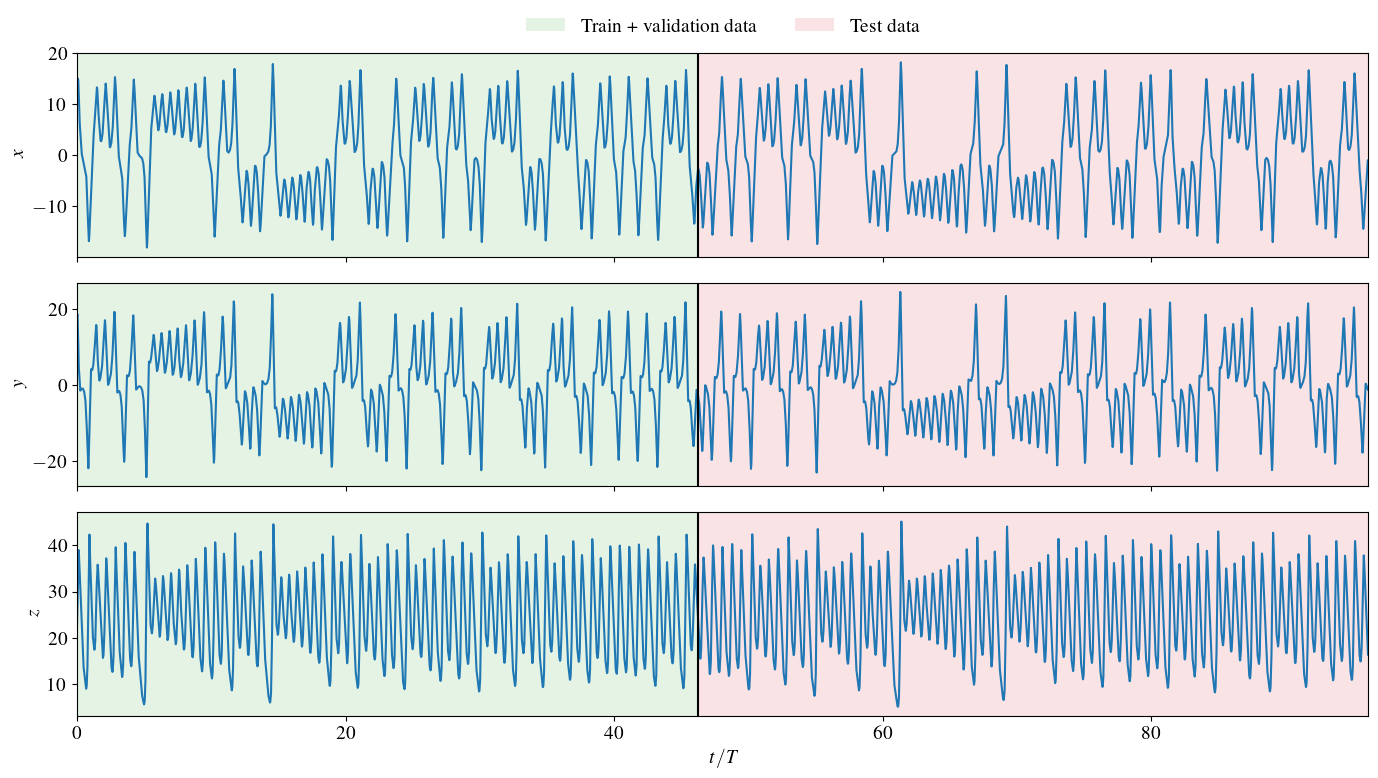

In [14]:
# Visualize the training dataset
fig = plt.figure(figsize=(14, 8), layout='tight')
axs = fig.subplots(nrows=model.Nphi, ncols=1, sharex='col', sharey='row')
for axi, ax in enumerate(axs):
    ax.plot(model.hist_t/t_lyap, model.hist[:, axi])
    ax.axvline(x=model.hist_t[-N_test_model]/t_lyap, color='k')
    ax.axvspan(0, model.hist_t[-N_test_model]/t_lyap, facecolor='tab:green', alpha=0.125, zorder=-100, label='Train + validation data')
    ax.axvspan(model.hist_t[-N_test_model]/t_lyap, model.hist_t[-1]/t_lyap, facecolor='tab:red', alpha=0.125, zorder=-100, label='Test data')
    ax.set(ylabel=model.obs_labels[axi])
    if axi == 0:
        ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1.0))
axs[-1].set(xlabel='$t/T$', xlim=[0, model.hist_t[-1]/t_lyap])

## 3. TRAIN THE ESN
The result of the ESN training is the output matrix. It is interesting to visualize the weights of Wout. 
NB: Different initializations result in different matrices.

In [15]:
train_data = model.get_observable_hist()
train_data = train_data.transpose(2, 0, 1)  # Note: input must be L x Nt x Ndim

# Train ESN
ESN_original.train(data=train_data)


(1, 7075, 3)

 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 15 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-12	 -1.1652
2	 2.000e-01	 1.581e+00	 1.000e-06	 -1.0343
3	 2.000e-01	 5.000e+00	 1.000e-06	 -1.2891
4	 2.000e-01	 1.581e+01	 1.000e-06	 -0.7746
5	 2.000e-01	 5.000e+01	 1.000e-06	 0.7225
6	 3.500e-01	 5.000e-01	 1.000e-09	 -0.3849
7	 3.500e-01	 1.581e+00	 1.000e-06	 -0.8987
8	 3.500e-01	 5.000e+00	 1.000e-12	 -1.2428
9	 3.500e-01	 1.581e+01	 1.000e-06	 -0.4886
10	 3.500e-01	 5.000e+01	 1.000e-06	 3.0013
11	 5.000e-01	 5.000e-01	 1.000e-12	 -0.3611
12	 5.000e-01	 1.581e+00	 1.000e-06	 -1.1668
13	 5.000e-01	 5.000e+00	 1.000e-06	 -1.1458
14	 5.000e-01	 1.581e+01	 1.000e-06	 0.4172
15	 5.000e-01	 5.000e+01	 1.000e-06	 3.2708
16	 6.500e-01	 5.000e-01	 1.000e-06	 0.0661
17	 6.500e-01	 1.581e+00	 1.000e-06	 -1.1457
18	 6.500e-01	 5.000e+00	 1.000e-06	 -1.2743
19	 6.500e-01	 1.581e+01	 1.000e-06	 1.7512
20

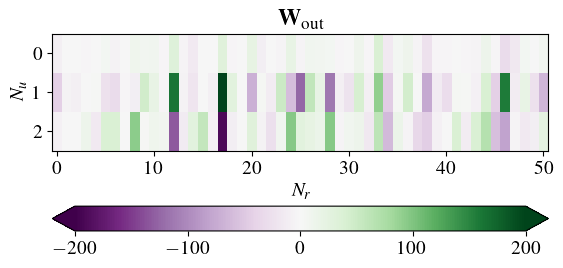

In [16]:
# Visualize the outout matrix
fig, ax = plt.subplots()
im = ax.matshow(ESN_original.Wout.T, cmap="PRGn", aspect=4., vmin=-200, vmax=200)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
cbar=plt.colorbar(im, orientation='horizontal', extend='both')
ax.set(ylabel='$N_u$', xlabel='$N_r$', title='$\mathbf{W}_\mathrm{out}$');

## 4. TEST THE ESN'S ADAPTABILITY TO SEQUENTIAL INPUT DATA

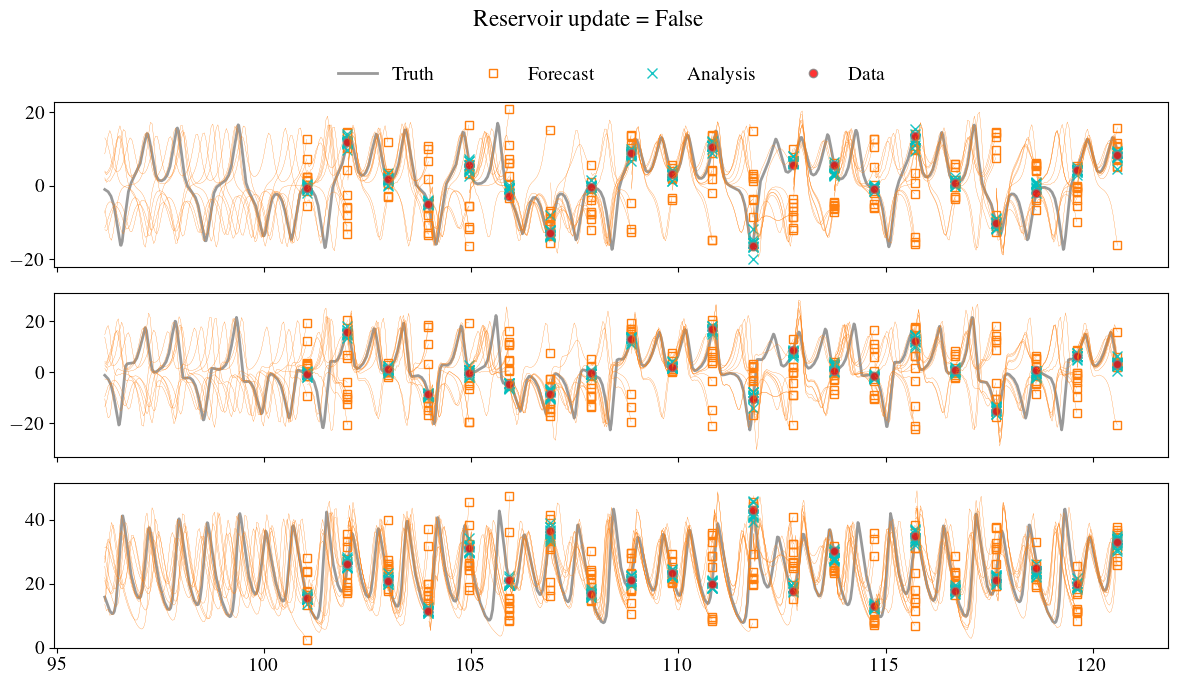

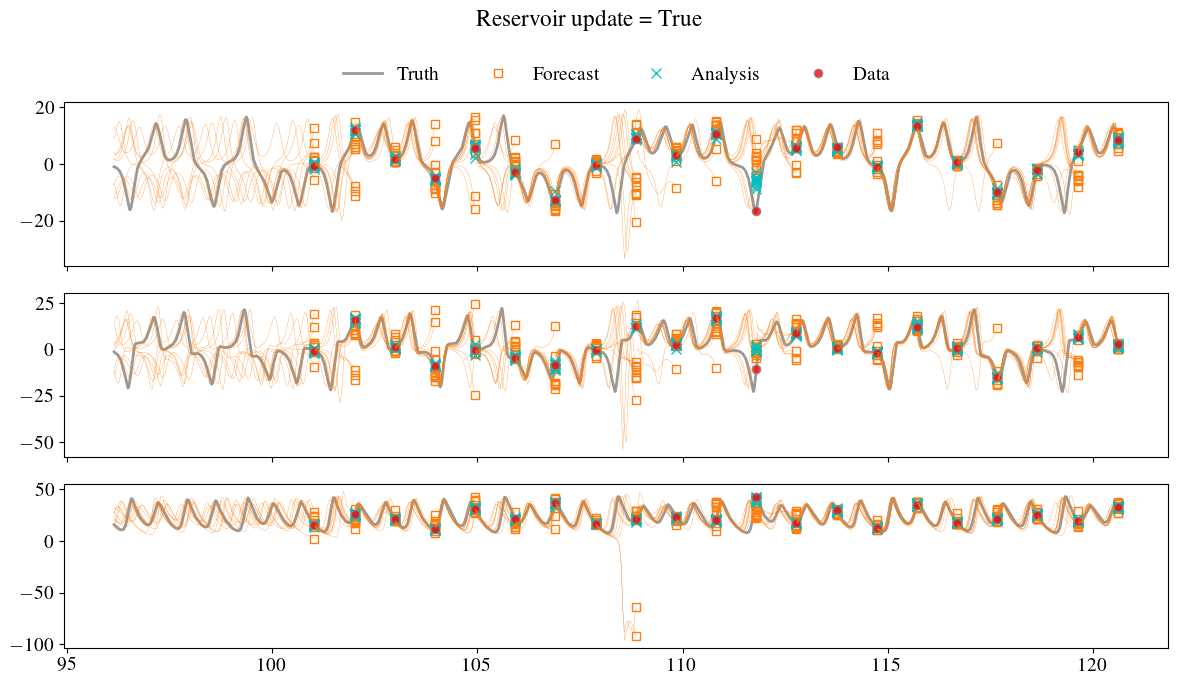

In [17]:

plt.style.use('fast')


# Select the time windows of interest
dt_DA = 1. * t_lyap
total_time = 20. * t_lyap
num_tests = int(total_time / dt_DA)

# Make a copy of the blank ESN
ESN_2 = deepcopy(ESN_original)
# Select observable states
observe_idx = np.array([0, 1 ,2])
N_ens = 10

ESN_2.observed_idx = observe_idx
ESN_2.bayesian_update = True
ESN_2.initialize_state(data=train_data, N_ens=N_ens)

Nt_tests = int(dt_DA / ESN_2.dt_ESN)
Nt_tests_model = Nt_tests * ESN_2.upsample

from essentials.DA import EnSRKF

for update_reservoir in [False, True]:
    
    ESN_case = deepcopy(ESN_2)
    truth = model.copy()


    FORECAST, FORECAST_TIME, ANALYSIS, TRUTH, TRUTH_TIME = [], [], [], [], []
    
    Cdd = (0.05 * 10) ** 2 * np.eye(len(ESN_case.observed_idx))
    
    for jj in range(num_tests + 1):
        # Forecast truth
        if jj == 0:
            psi, tt = truth.time_integrate(Nt_tests_model * 5)
            u_closed, r_closed = ESN_case.closedLoop(Nt_tests * 5)
        else:
            psi, tt = truth.time_integrate(Nt_tests_model)
            u_closed, r_closed = ESN_case.closedLoop(Nt_tests)
            
        # Update model and ESN states
        truth.update_history(psi, tt)
        u_closed, r_closed = u_closed[1:], r_closed[1:]
        tt_up = tt[::ESN_case.upsample].copy()
    
        if not Nt_tests_model % Nt_tests:
            u_closed[-1] = interpolate(tt_up, u_closed, tt[-1])
            r_closed[-1] = interpolate(tt_up, r_closed, tt[-1])
            tt_up[-1] = tt[-1].copy()

            
        ESN_case.reset_state(u=u_closed[-1], r=r_closed[-1])
    
        # Take measurement of the truth
        d = psi[-1, observe_idx, 0]
    
        # Update ESN with analysis state
        u_hat, r_hat = ESN_case.reconstruct_state(observed_data=d, update_reservoir=update_reservoir, filter_=EnSRKF)
        ESN_case.reset_state(u=u_hat, r=r_hat)
    
        TRUTH.append(psi)
        TRUTH_TIME.append(tt)
        FORECAST.append(u_closed)
        FORECAST_TIME.append(tt_up)
        ANALYSIS.append(u_hat)
        
    fig1 = plt.figure(figsize=(12, 7),layout="tight")
    axs_time = fig1.subplots(nrows=ESN_case.N_dim, ncols=1, sharex='col', sharey='row')
    
    ct, cf, ca, co = 'gray', 'tab:orange', 'c', 'r'
    lbl_a, lbl_f = [[lbl] + [None] * (N_ens-1) for lbl in  ['Analysis', 'Forecast']]
    
    flag = 0
    for axi, ax in enumerate(axs_time):
        ax.plot(np.concatenate(TRUTH_TIME) / t_lyap, np.concatenate(TRUTH)[:, axi], '-', c=ct, lw=2, alpha=.8, label='Truth')
        for yt, tt, uf, tf, ua in zip(TRUTH, TRUTH_TIME, FORECAST, FORECAST_TIME, ANALYSIS):
            ax.plot(tf / t_lyap, uf[:, axi], '-', c=cf, lw=0.2, label=[None]*N_ens)
            ax.plot(tf[-1] / t_lyap, uf[[-1], axi], 's', lw=0, mew=1, c=cf, mec=cf, mfc='none', ms=6, label=lbl_f)
            ax.plot(tf[-1] / t_lyap, ua[[axi]], 'x', c=ca, mec=ca, ms=7, label=lbl_a, alpha=0.9)
            if axi in observe_idx:
                ax.plot(tt[-1] / t_lyap, yt[-1, axi], 'o', c=ct, mfc=co, ms=6, alpha=.8, label='Data')
            if not flag and axi == 0:
                ax.legend(ncols=4, loc='lower center', bbox_to_anchor=(0.5, 1.0))
                flag = True
                
                
    plt.suptitle('Reservoir update = {}'.format(update_reservoir))
    
    